# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

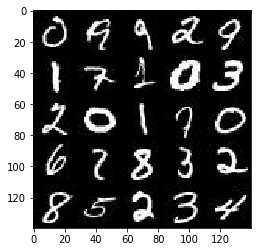

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

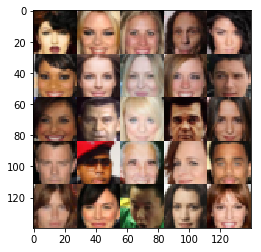

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_images')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input_images, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [23]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        x = tf.maximum(x, alpha * x)
        # 14*14*64
        
        x = tf.layers.conv2d(x, 128, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x, alpha * x)
        # 7*7*128
        
        x = tf.reshape(x, (-1, 7 * 7 * 128))
        
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [36]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7 * 7 * 512)

        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, alpha * x)
        # 7x7x512
        
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, alpha * x)
        # 14x14x256

        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 4, strides=2, padding='same')

        out = tf.tanh(logits)

        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [37]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [38]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [40]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data (n_images, width, height, image_channels)
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    total_images, image_width, image_height, image_channels = data_shape

    # Build network
    real_inputs, z_inputs, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, image_channels, alpha=alpha)

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    n_batches = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Multiply value by 2 to change value range from [-0.5, 0.5] to [-1.0, 1.0]
                images_input = np.dot(batch_images, 2)
                n_batches += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt,
                             feed_dict={real_inputs: images_input, z_inputs: batch_z, lr: learning_rate})
                _ = sess.run(g_opt,
                             feed_dict={z_inputs: batch_z, real_inputs: images_input, lr: learning_rate})

                if n_batches % print_every == 0:
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: images_input})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if n_batches % show_every == 0:
                    show_generator_output(sess, 25, z_inputs, image_channels, data_image_mode)
        print("Result for trained generator:")
        show_generator_output(sess, 25, z_inputs, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.9360... Generator Loss: 0.0775
Epoch 1/2... Discriminator Loss: 2.0627... Generator Loss: 0.2432
Epoch 1/2... Discriminator Loss: 2.3837... Generator Loss: 0.2797
Epoch 1/2... Discriminator Loss: 2.0539... Generator Loss: 0.4219
Epoch 1/2... Discriminator Loss: 1.6262... Generator Loss: 0.5353
Epoch 1/2... Discriminator Loss: 1.5478... Generator Loss: 0.5509
Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 0.5664
Epoch 1/2... Discriminator Loss: 1.5167... Generator Loss: 0.5423
Epoch 1/2... Discriminator Loss: 1.4683... Generator Loss: 0.5972
Epoch 1/2... Discriminator Loss: 1.4777... Generator Loss: 0.5536


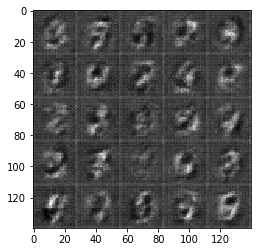

Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.6286
Epoch 1/2... Discriminator Loss: 1.4420... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 1.4177... Generator Loss: 0.7278
Epoch 1/2... Discriminator Loss: 1.4304... Generator Loss: 0.6592
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 0.8022
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.8640
Epoch 1/2... Discriminator Loss: 1.2482... Generator Loss: 0.7555


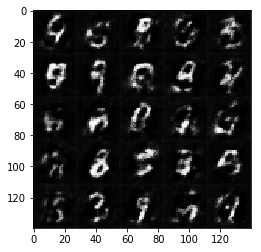

Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.5873
Epoch 1/2... Discriminator Loss: 1.2929... Generator Loss: 0.8116
Epoch 1/2... Discriminator Loss: 1.2387... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.9875
Epoch 1/2... Discriminator Loss: 1.0907... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 0.8460
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 1.1228
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.8580


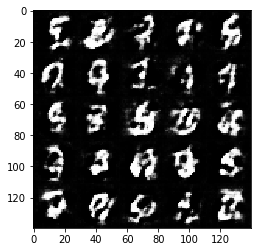

Epoch 1/2... Discriminator Loss: 1.0789... Generator Loss: 0.9200
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 0.7620
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 0.9955
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 0.7633
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 0.9004
Epoch 1/2... Discriminator Loss: 1.1003... Generator Loss: 1.0940
Epoch 1/2... Discriminator Loss: 1.0701... Generator Loss: 0.8671
Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 0.6731
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 1.0902
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 0.7976


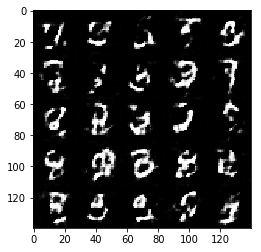

Epoch 1/2... Discriminator Loss: 1.0967... Generator Loss: 0.9566
Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 0.6060
Epoch 1/2... Discriminator Loss: 1.0943... Generator Loss: 1.1098
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 1.0465
Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 0.9186
Epoch 2/2... Discriminator Loss: 1.0881... Generator Loss: 1.2352
Epoch 2/2... Discriminator Loss: 1.1338... Generator Loss: 0.9988
Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 0.9574


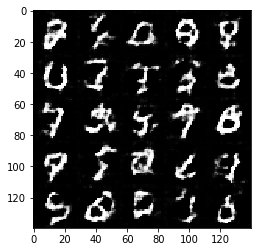

Epoch 2/2... Discriminator Loss: 1.1170... Generator Loss: 0.6665
Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 0.9165
Epoch 2/2... Discriminator Loss: 1.1577... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 0.9640
Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 0.5063
Epoch 2/2... Discriminator Loss: 1.2099... Generator Loss: 0.9250
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 1.1778... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 0.4803
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 0.9745


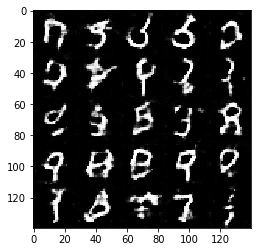

Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 0.7086
Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 0.7068
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 0.6131
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 0.6231
Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 0.8149
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.9206
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.6424


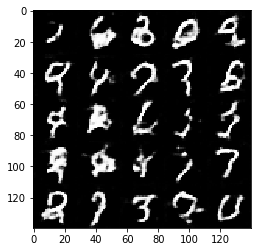

Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 1.2022... Generator Loss: 0.6579
Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 0.6158
Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 0.7560
Epoch 2/2... Discriminator Loss: 1.1827... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 1.2422... Generator Loss: 0.8322
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.4934
Epoch 2/2... Discriminator Loss: 1.1958... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 1.2124... Generator Loss: 0.7517
Epoch 2/2... Discriminator Loss: 1.2385... Generator Loss: 0.7376


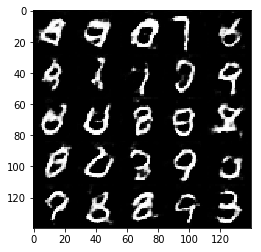

Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.4508
Epoch 2/2... Discriminator Loss: 1.1927... Generator Loss: 0.6943
Epoch 2/2... Discriminator Loss: 1.1827... Generator Loss: 0.8450
Epoch 2/2... Discriminator Loss: 1.2187... Generator Loss: 0.7520
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.8125
Epoch 2/2... Discriminator Loss: 1.1398... Generator Loss: 0.8197
Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 0.7970
Epoch 2/2... Discriminator Loss: 1.1376... Generator Loss: 0.7765
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 0.7166


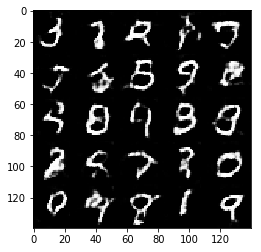

Epoch 2/2... Discriminator Loss: 1.1950... Generator Loss: 0.9892
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.9083
Epoch 2/2... Discriminator Loss: 1.1808... Generator Loss: 0.8138
Result for trained generator:


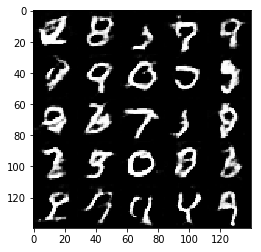

In [41]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.3837... Generator Loss: 0.0211
Epoch 1/1... Discriminator Loss: 4.7879... Generator Loss: 0.0247
Epoch 1/1... Discriminator Loss: 3.0974... Generator Loss: 0.1098
Epoch 1/1... Discriminator Loss: 3.3690... Generator Loss: 0.1458
Epoch 1/1... Discriminator Loss: 3.2464... Generator Loss: 0.2239
Epoch 1/1... Discriminator Loss: 2.6216... Generator Loss: 0.3128
Epoch 1/1... Discriminator Loss: 2.4525... Generator Loss: 0.3602
Epoch 1/1... Discriminator Loss: 2.2552... Generator Loss: 0.4198
Epoch 1/1... Discriminator Loss: 2.2936... Generator Loss: 0.3535
Epoch 1/1... Discriminator Loss: 2.0759... Generator Loss: 0.4482


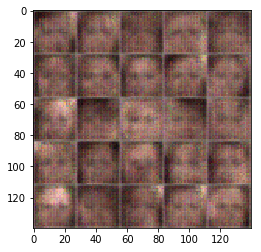

Epoch 1/1... Discriminator Loss: 1.9982... Generator Loss: 0.4287
Epoch 1/1... Discriminator Loss: 2.0346... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 1.8945... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 1.8745... Generator Loss: 0.4969
Epoch 1/1... Discriminator Loss: 1.9250... Generator Loss: 0.4380
Epoch 1/1... Discriminator Loss: 1.8502... Generator Loss: 0.5098
Epoch 1/1... Discriminator Loss: 1.7815... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.7383... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.7827... Generator Loss: 0.4634
Epoch 1/1... Discriminator Loss: 1.7401... Generator Loss: 0.4750


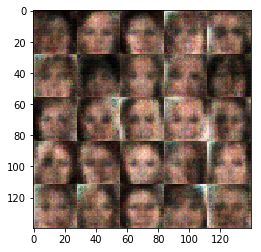

Epoch 1/1... Discriminator Loss: 1.6877... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.6744... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.6828... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.6230... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.6816... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.5783


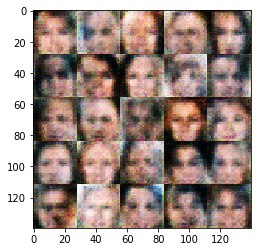

Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.6185... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 0.6629


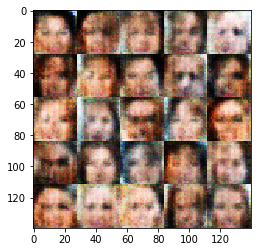

Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.6275... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.5772... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.6714... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.6241


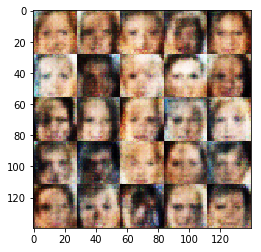

Epoch 1/1... Discriminator Loss: 1.5931... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.6143


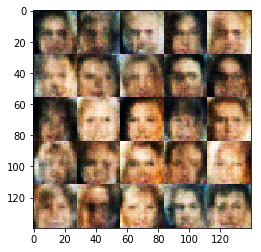

Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.6852


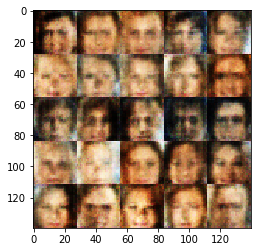

Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7225


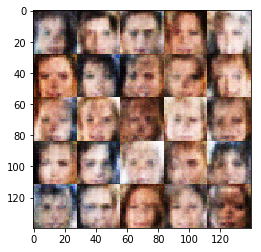

Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7070


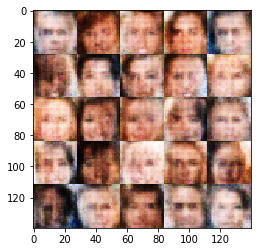

Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6748


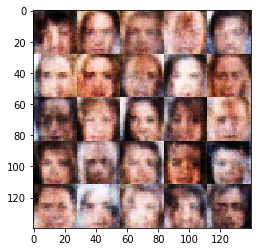

Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6356


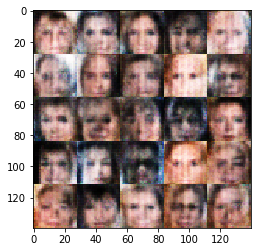

Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.6586


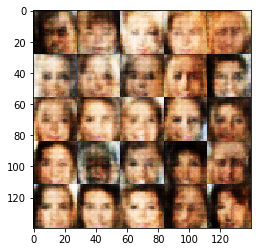

Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6036


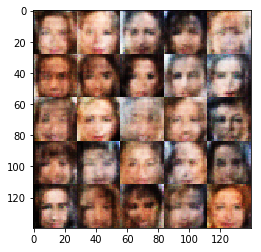

Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6925


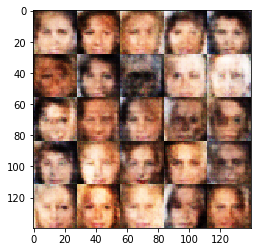

Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6357


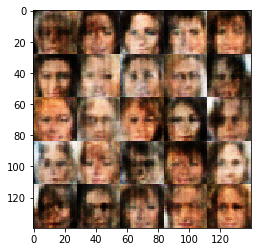

Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7053
Result for trained generator:


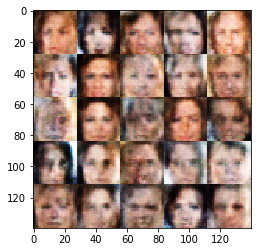

In [42]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.